## 1. Setup

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
import shap
shap.initjs()

In [67]:
df = pd.read_csv('Anemia.csv')

## 2. Exploratory Data Analysis (EDA)

Primero es necesario que conozcamos con cuantos datos contamos y que tipo de datos son.

In [68]:
print("La cantidad de datos que contiene el dataset crudo es de: ", df.shape[0])

La cantidad de datos que contiene el dataset crudo es de:  104


Ahora vemos cuales son los nombres de las columnas y que puede significar cada una de ellas.

In [69]:
columnas = "\n"
for col in df.columns:
    columnas += col + ", \n"

columnas = columnas[:-3]
print("Las columnas que contiene el dataset crudo son: ", columnas)

Las columnas que contiene el dataset crudo son:  
Number, 
Sex, 
%Red Pixel, 
%Green pixel, 
%Blue pixel, 
Hb, 
Anaemic


Number: Se refiere al número de la fila.

Sex: Se refiere al sexo de la persona.

%Red Pixels: Se refiere al porcentaje de pixeles rojos en la imagen.

%Green Pixels: Se refiere al porcentaje de pixeles verdes en la imagen.

%Blue Pixels: Se refiere al porcentaje de pixeles azules en la imagen.

Hb: Se refiere a la hemoglobina en la sangre.

Anemic: Se refiere a si la persona es anémica o no (varaible objetivo). 1 significa que tiene anemia y 0 que no tiene.

In [70]:
#Evaluar datos faltantes

df = df.drop(columns='Number')

for column in df.columns:
    print("Datos faltantes en la columna "+ column + "son: "+ str(df[column].isna().sum()))

Datos faltantes en la columna Sexson: 0
Datos faltantes en la columna %Red Pixelson: 0
Datos faltantes en la columna %Green pixelson: 0
Datos faltantes en la columna %Blue pixelson: 0
Datos faltantes en la columna Hbson: 0
Datos faltantes en la columna Anaemicson: 0


**Ahora es necesario que veamos la distribución y valores de nuestros datos**

Para poder ver la distribución de los datos, es necesario hacer un label encoding de la variable objetivo y al sexo. En los comentarios del dataset se menciona que el sexo tiene un typo y tiene un espacio por lo que lo quitaremos para poder hacer el label encoding.

In [71]:
df['Sex'] = df['Sex'].str.strip().map(lambda x: x.upper() if isinstance(x, str) else x)
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)

df['Anaemic'] = df['Anaemic'].str.strip().map(lambda x: x.lower() if isinstance(x, str) else x)
df['Anaemic'] = df['Anaemic'].map({'yes': 1, 'no': 0}).fillna(-1).astype(int)

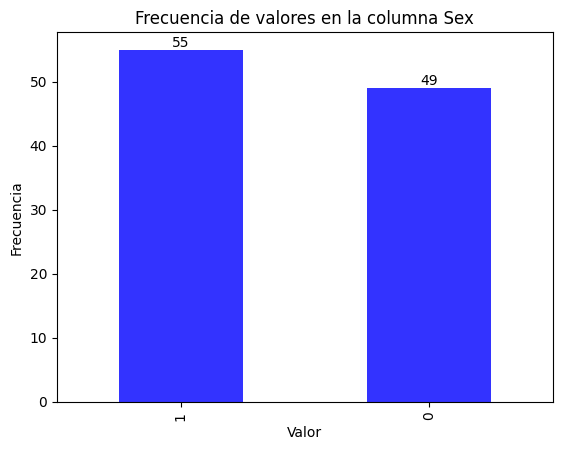

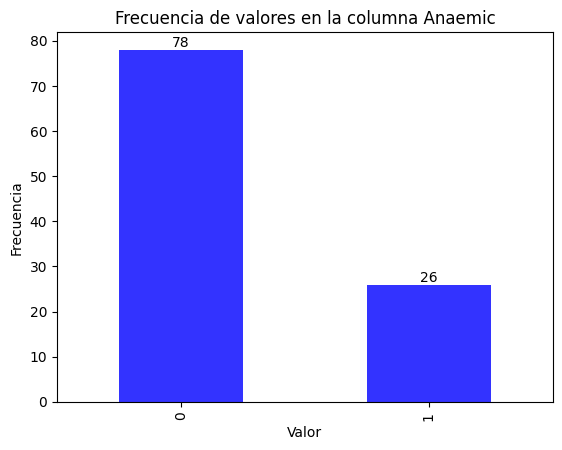

In [72]:
columns = ['Sex', 'Anaemic']

# Filtrar solo las columnas numéricas para hacer los histogramas
numeric_columns = df.select_dtypes(include=[np.number])

# Crear histogramas para cada columna numérica
for column in columns:
    frecuencia = df[column].value_counts()
    
    # Graficar la frecuencia como un gráfico de barras
    plt.figure()
    ax = frecuencia.plot(kind='bar', color='blue', alpha=0.8)
    plt.title(f'Frecuencia de valores en la columna {column}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

    # Añadir el número de elementos contados encima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, str(int(height)), 
                ha='center', va='bottom')
    
    plt.show()


A primera instancia podemos ver que el dataset es bastante pequeño, con unicamente 104 registros de los cuales 55 son hombres y 49 son mujeres. En cuanto a nuestro variable objetivo, podemos ver que hay 78 personas que no son anémicas y 26 que si lo son. Esto puede que sea un problema ya que la clase objetivo está desbalanceada.

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22184\4253000193.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Anaemic', data=proporcion_anemia, palette='viridis')


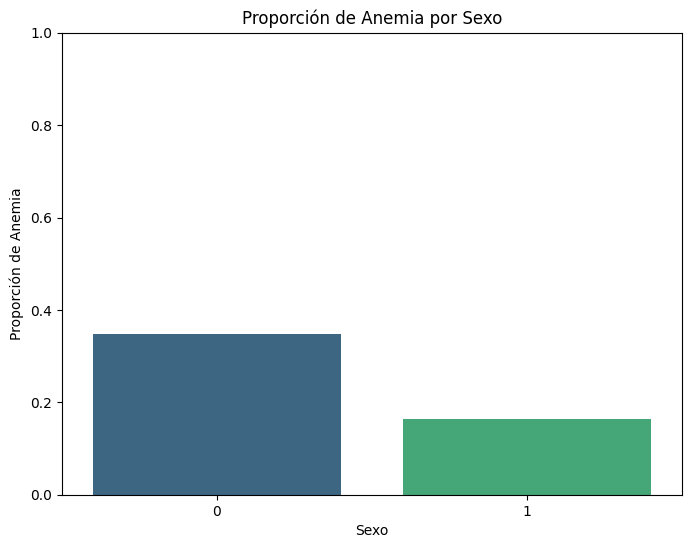

In [73]:
proporcion_anemia = df.groupby('Sex')['Anaemic'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Sex', y='Anaemic', data=proporcion_anemia, palette='viridis')
plt.title('Proporción de Anemia por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Proporción de Anemia')
plt.ylim(0, 1)  # Para que la proporción esté entre 0 y 1
plt.show()


Podemos ver que en los datos proporcionados, las mujeres son más propensas a ser anémicas que los hombres.

**Ahora es necesario que analizemos las columnas de porcentaje de color**

Es neecesario ver la distribución de los datos para validar que no existan valores atípicos y entender como estos se compartan.

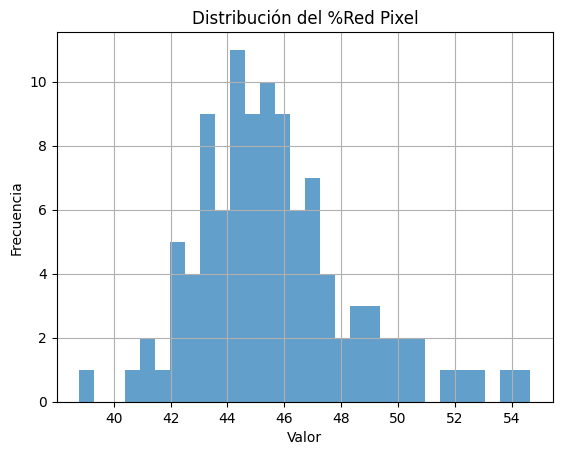

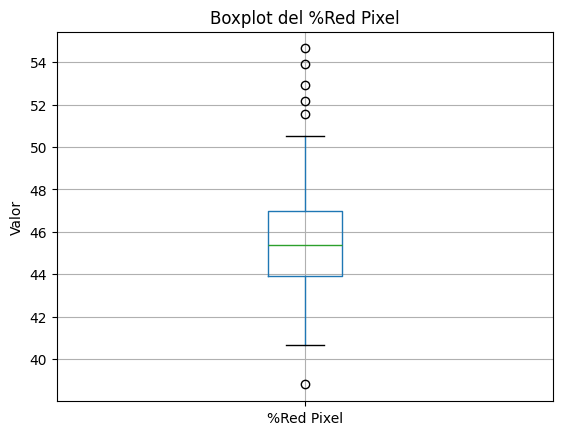

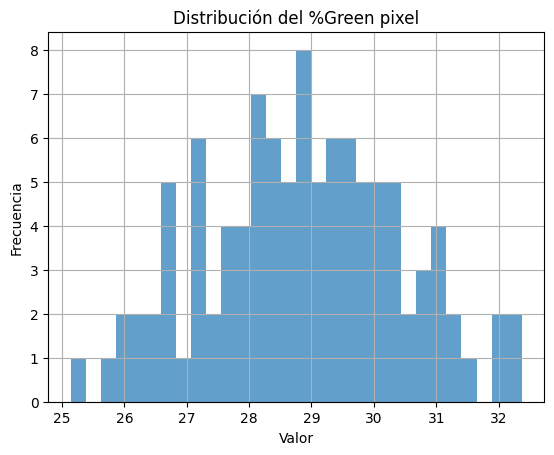

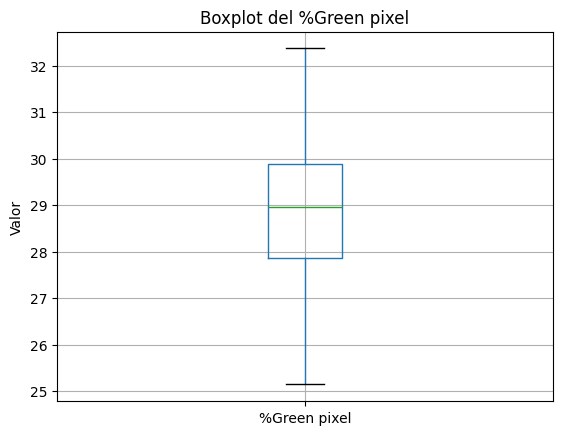

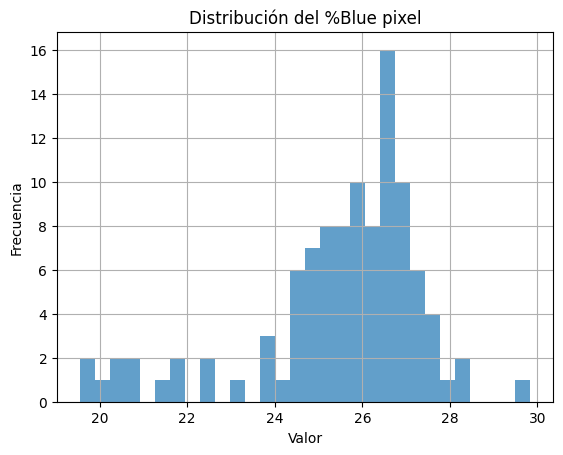

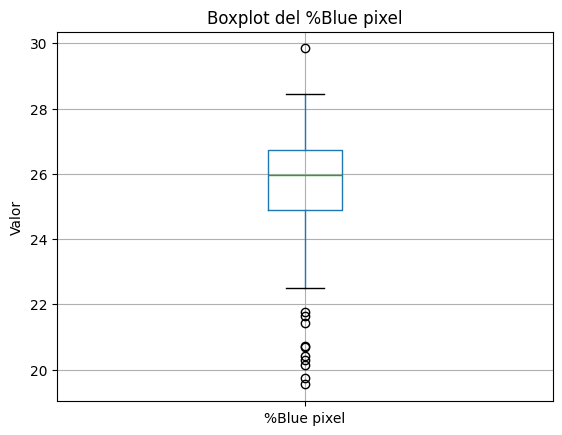

In [74]:
import matplotlib.pyplot as plt

columns = ['%Red Pixel', '%Green pixel', '%Blue pixel']
for column in columns:
    plt.figure()
    df[column].hist(bins=30, alpha=0.7)
    plt.title(f'Distribución del {column}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()

    plt.figure()
    df.boxplot(column=column)
    plt.title(f'Boxplot del {column}')
    plt.ylabel('Valor')
    plt.show()


Podemos ver que los datos tiene sentido ya que estamos trabajando con porcentajes y estos no pueden ser mayores a 100 ni menores a 0. Para las distribuciones de pixeles rojos y azules, existen datos atípicos.

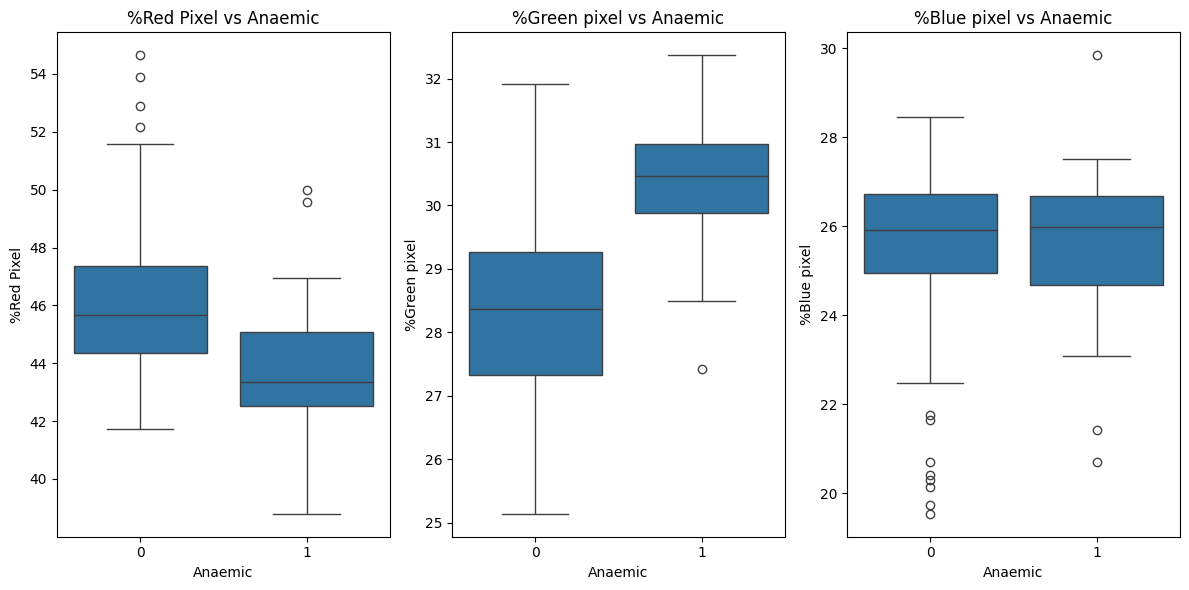

In [75]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(['%Red Pixel', '%Green pixel', '%Blue pixel'], start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Anaemic', y=column, data=df)
    plt.title(f'{column} vs Anaemic')
plt.tight_layout()
plt.show()


Al analizar el gráfico anterior podemos ver que el porcentaje del color azul no varía tanto si se tiene o no anemia, sin embargo, el porcentaje de color rojo y verde si varía, en definitiva el cambio es más notorio en el verde. Por lo que podemos decir que estas dos variables son posibles candidatas importantes para nuestro modelo.

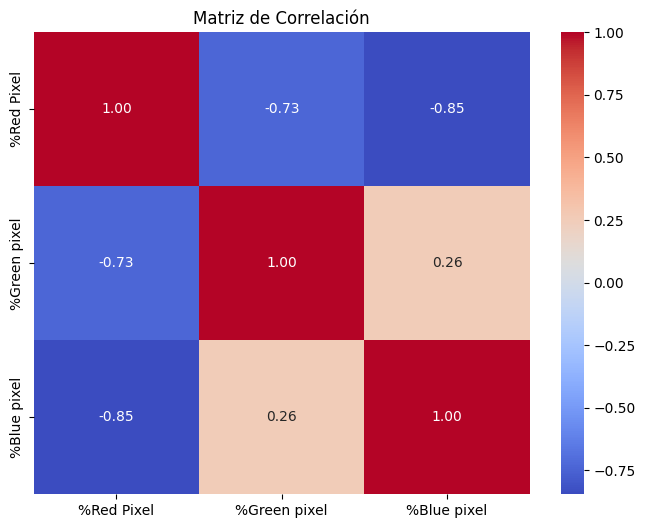

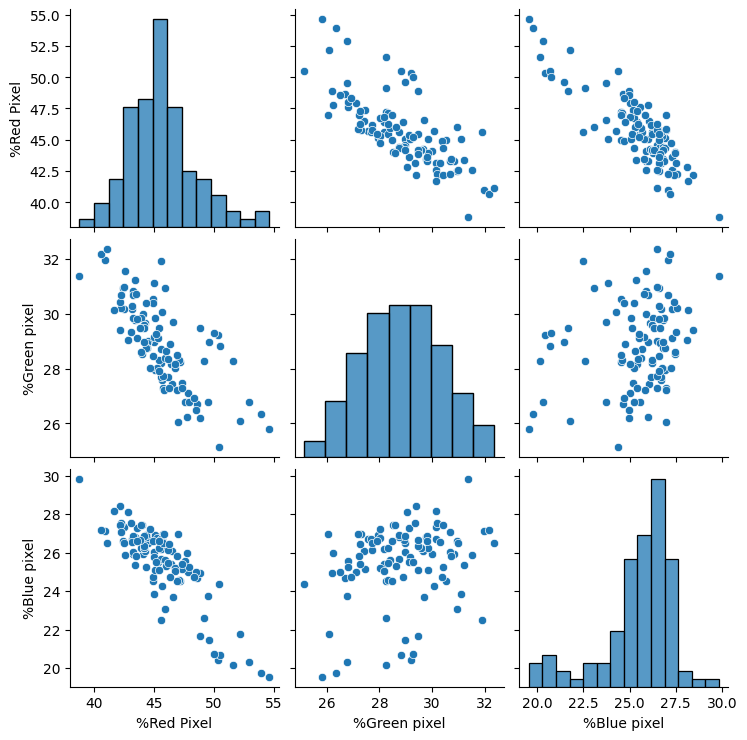

In [76]:
import seaborn as sns

# Matriz de correlación
plt.figure(figsize=(8, 6))
correlation_matrix = df[['%Red Pixel', '%Green pixel', '%Blue pixel']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

# Scatter plots
sns.pairplot(df[['%Red Pixel', '%Green pixel', '%Blue pixel']])
plt.show()


Con los dos graficos de arriba podemos ver que existe una relación negativa entre los colores lo cual tiene sentido ya que si un color aumenta el otro disminuye. Pero esto no nos dice mucho sobre la relación con la anemia.

**Y por ultimo evaluamos la hemoglobina**

In [77]:
print(df['Hb'].describe())

count    104.000000
mean      12.150962
std        2.512957
min        2.800000
25%       10.650000
50%       12.600000
75%       14.000000
max       16.300000
Name: Hb, dtype: float64


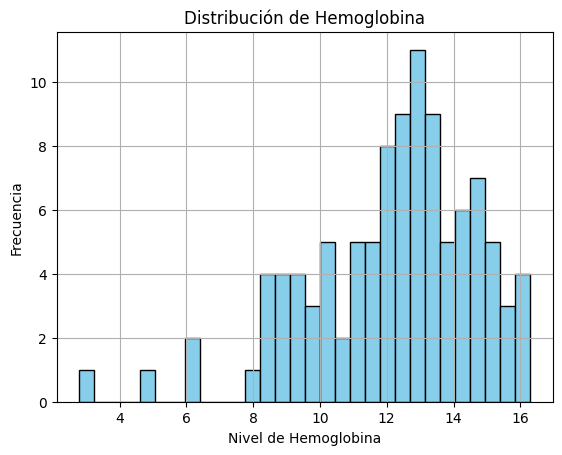

In [78]:
plt.figure()
df['Hb'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Hemoglobina')
plt.xlabel('Nivel de Hemoglobina')
plt.ylabel('Frecuencia')
plt.show()


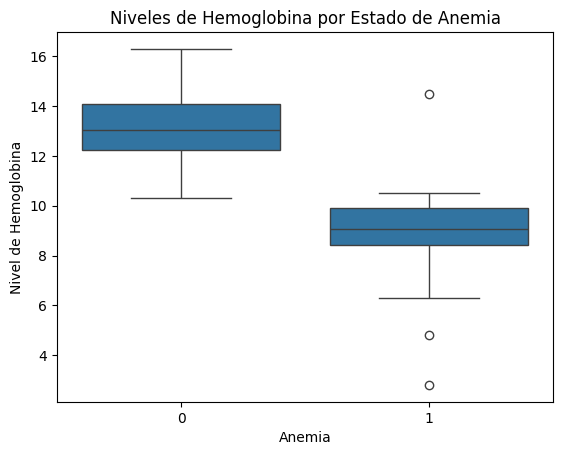

In [79]:
plt.figure()
sns.boxplot(x='Anaemic', y='Hb', data=df)
plt.title('Niveles de Hemoglobina por Estado de Anemia')
plt.xlabel('Anemia')
plt.ylabel('Nivel de Hemoglobina')
plt.show()


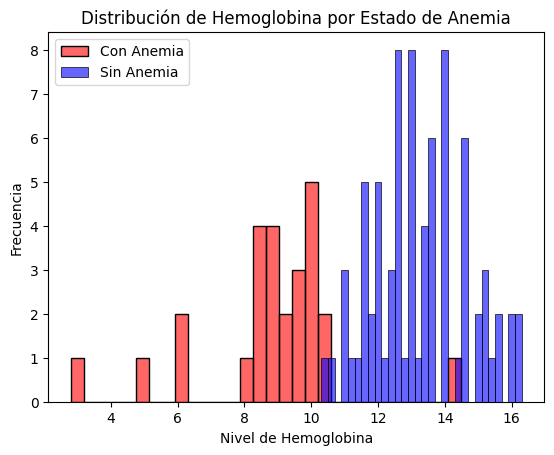

In [80]:
plt.figure()
sns.histplot(df[df['Anaemic'] == 1]['Hb'], bins=30, color='red', label='Con Anemia', alpha=0.6)
sns.histplot(df[df['Anaemic'] == 0]['Hb'], bins=30, color='blue', label='Sin Anemia', alpha=0.6)
plt.title('Distribución de Hemoglobina por Estado de Anemia')
plt.xlabel('Nivel de Hemoglobina')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


Podemos ver que los datos si son coherentres ya que la hemoglobina es baja en las personas anémicas y alta en las que no lo son exceptuando por un valor atipico de las personas anemicas. Por lo que podemos decir que esta variable es importante para nuestro modelo.

**Un poco de feature engineering con decision tree**

A continuación se hará feature engineering con un árbol de decisión. Esto servirá para evaluar qué variables son las más importantes para la predicción. También se podrá hacer un contraste con la explicabilidad que da este modelo y la explicabilidad de los valores SHAP.

In [81]:
# Separar características y variable objetivo
X = df.drop(columns='Anaemic')  # Características
y = df['Anaemic']               # Etiqueta

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtener la importancia de las características y sus nombres
importances = model.feature_importances_
feature_names = X.columns

# Mostrar la importancia de las características en un DataFrame
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

        feature  importance
4            Hb    0.876568
2  %Green pixel    0.095622
3   %Blue pixel    0.027810
0           Sex    0.000000
1    %Red Pixel    0.000000


Se puede observar del análisis anterior, que la característica más importante en la predicción es el nivel de hemoglobina en la sangre. Luego, el porcentaje de pixeles verdes en mucha menor medida, al igual que de azules. Finalmente el sexo y el porcentaje de pixeles rojos no influyen en la decisión

**Resumen de hallazgos:**

El porcentaje de color verde tiende a ser mayor cuando se tiene anemia. La hemoglobina tiende a ser menor cuando se tiene anemia. El dataset cuenta con más mujeres anémicas que hombres. La clase objetivo está desbalanceada.

## 3. Modelos de Predicción

In [82]:
# Obtener variable objetivo y características para predicción
X = df.drop(columns='Anaemic')  # Características
y = df['Anaemic']               # Etiqueta

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.1 XGBoost

In [83]:
# Crear el modelo XGBoost
model_XGB = xgb.XGBClassifier()

# Entrenar el modelo
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

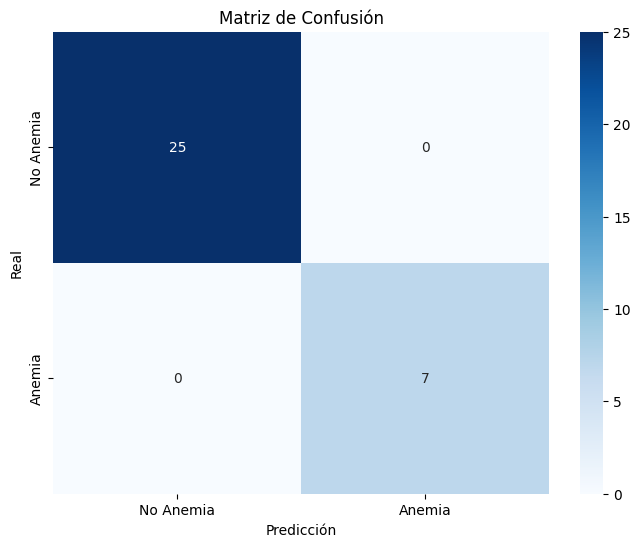

In [84]:
# Realizar predicciones
y_pred_xgb = model_XGB.predict(X_test)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Anemia', 'Anemia'], yticklabels=['No Anemia', 'Anemia'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


In [85]:
# Calcular y mostrar la precisión
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy:.2f}')

# Imprimir el informe de clasificación formateado
print('\nClassification Report:')
print(classification_report(y_test, y_pred_xgb, target_names=['No Anemia', 'Anemia']))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

   No Anemia       1.00      1.00      1.00        25
      Anemia       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



Como podemos ver el modelo tuvo 100% de precision lo que seguramente nos indica que el modelo tiene overfitting, lo cual es lógico debido a los pocos datos que tenemos.

### 3.2 Random Forest

In [86]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier()

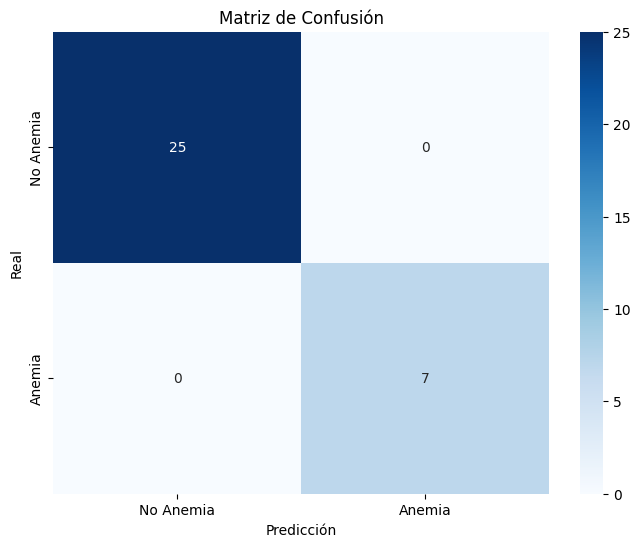

In [87]:
# Realizar predicciones
y_pred_rf = model_rf.predict(X_test)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Crear el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Anemia', 'Anemia'], yticklabels=['No Anemia', 'Anemia'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [88]:
# Calcular y mostrar la precisión
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy:.2f}')

# Imprimir el informe de clasificación formateado
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf, target_names=['No Anemia', 'Anemia']))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

   No Anemia       1.00      1.00      1.00        25
      Anemia       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



Se puede observar que la accuracy del modelo es de 100%, igual que su score F1. Esto quiere decir que a pesar de que los datos están desbalanceados, el modelo puede manejarlo. Sin embargo, el modelo definitivamente está sobreajustado, debido a los pocos datos que se tienen.

## 4. Análisis SHAP:

### 4.1 Análisis de XGBoost

#### **Valores Shap XGBoost**

In [89]:
explainer_xgb = shap.TreeExplainer(model_XGB, X_test)
shap_values_xgb = explainer_xgb.shap_values(X_test)


#### **SHAP Summary Plot**

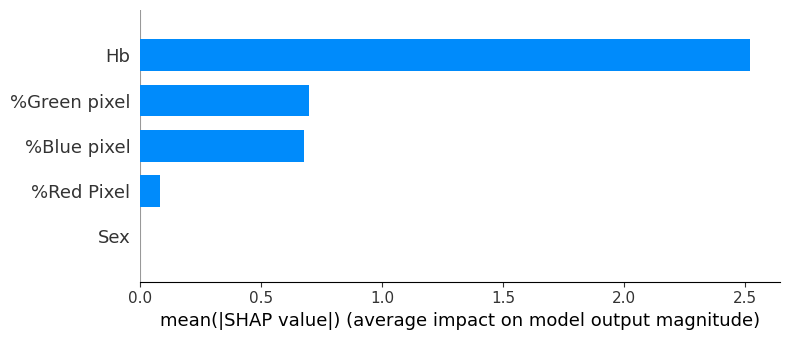

In [90]:
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

Se puede observar que, en general, la característica más importante es el nivel de hemoglobina en la sangre, luego la cantidad de pixeles verdes y azules en menor medida. Finalmente la cantidad de pixeles rojos no influye mucho y el sexo no influye en lo absoluto.

#### **SHAP Dependence Plots**

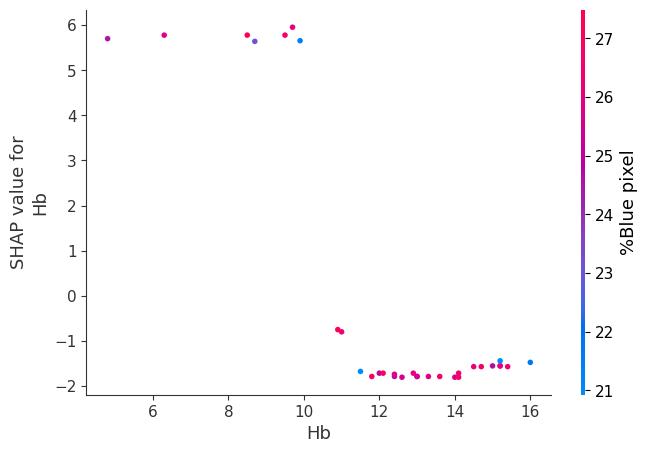

In [91]:
# Dependence Plot para una característica específica
shap.dependence_plot('Hb', shap_values_xgb, X_test)

Se puede observar que los valores de hemoglobina entre 4 y 10, influyen altamente en la predicción de la anemia. Mientras que valores arriba de 10, influyen a la predicción de no anemia.

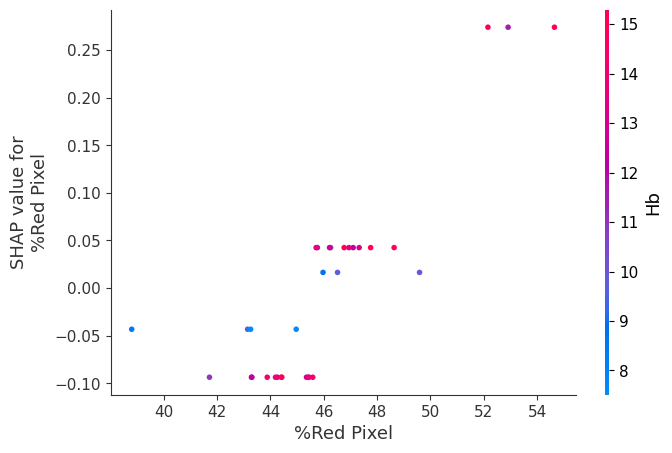

In [92]:
# Dependence Plot para una característica específica
shap.dependence_plot('%Red Pixel', shap_values_xgb, X_test)

Se puede observar que los valores de pixeles rojos entre 40 y 45 y que tienen alto o bajo nivel de hemoglobina, aportan más a la predicción de no anemia. Los valores entre 46 a 50 aportan medianamente a la predicción. Los valores de pixeles arriba de 52 con alta hemoglobina aportan más a determinar si se tiene anemia.

#### **SHAP Force Plots**

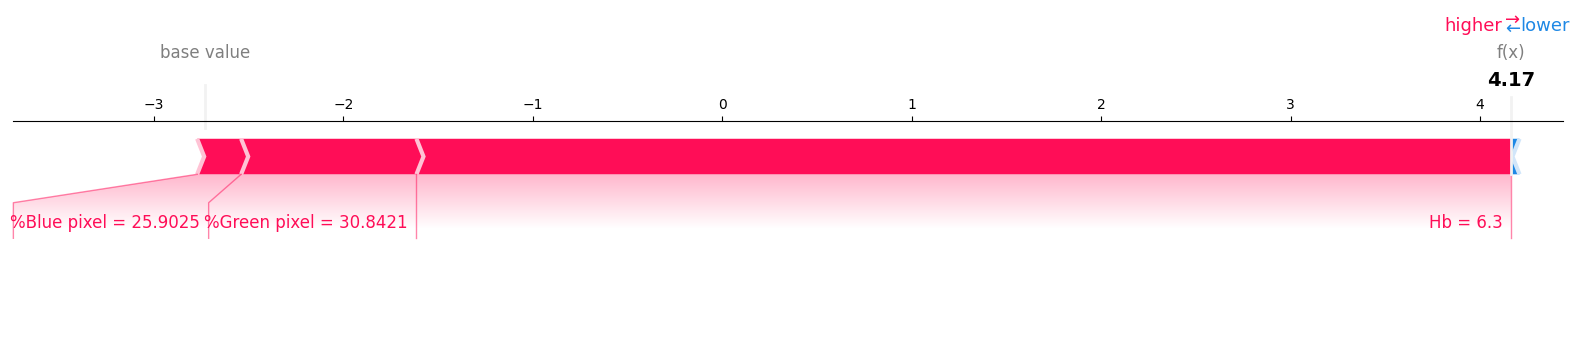

1


In [93]:
# Visualizar la predicción del primer ejemplo en X_test
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[9,:], X_test.iloc[9,:], matplotlib=True)
print(y_test.iloc[9])

Se puede observar que para una observación que tiene anemia, la predicción se realiza principalemtene en base al nivel de hemoglobina en la sangre y un poco en base a la cantidad de pixeles verdes.

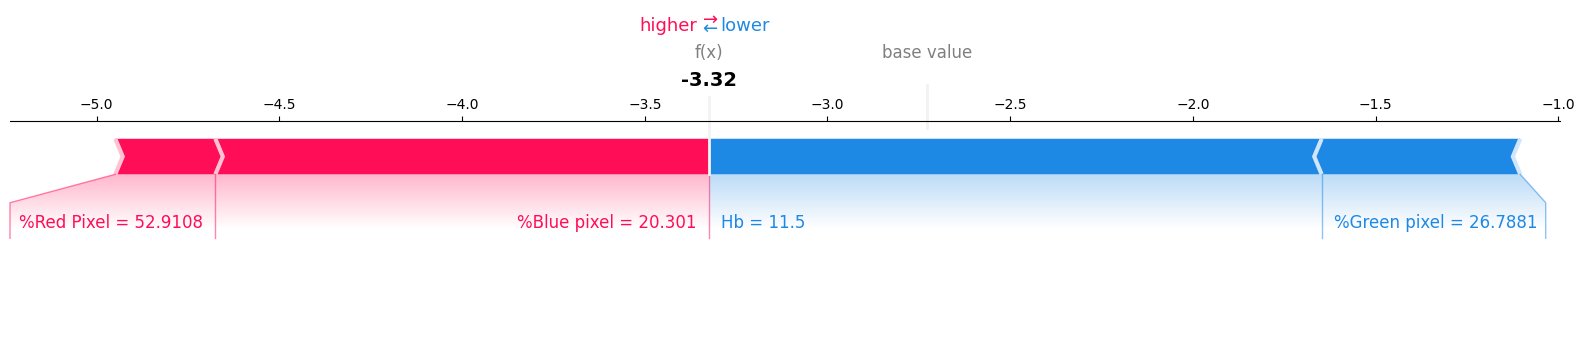

In [94]:
# Visualizar la predicción del primer ejemplo en X_test
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[25,:], X_test.iloc[25,:], matplotlib=True)

Se puede observar que para una predicción de no anemia, principalmente se usa el nivel de hemoglobina, pero en menor medida que para una predicción de anemia. Aquí, el porcentaje de pixeles verdes y azules influyen más en la predicción.

In [95]:
# Visualizar la predicción de múltiples ejemplos
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb, X_test)


Se puede observar en el gráfico, una vez más, como la hemoglobina es la que más influye en la predicción de la anemia a lo largo de las observaciones. Inicialmente influye más en la predicción de la presencia de anemia y luego en la ausencia de anemia. Predomina el color azul, porque la mayoría de observaciones no tienen anemia.

#### **Sesgo en predicciones**

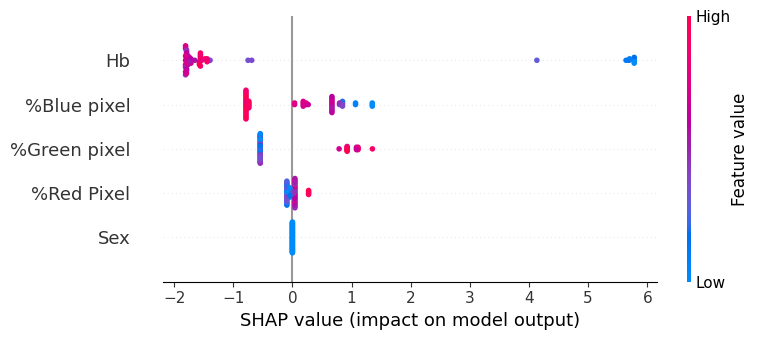

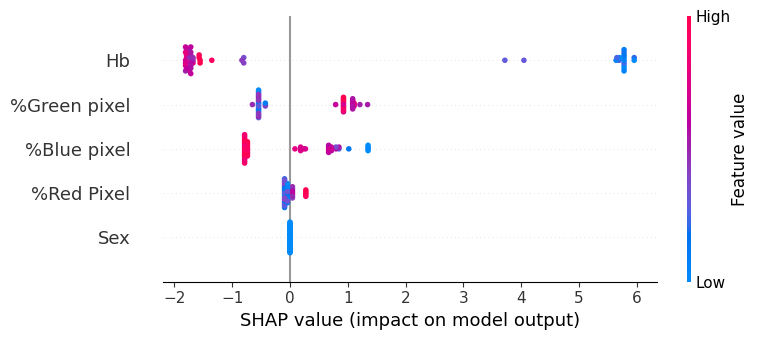

In [96]:
males = X[X['Sex'] == 1]
females = X[X['Sex'] == 0]

shap_values_m = explainer_xgb(males)
shap_values_f = explainer_xgb(females)

shap.summary_plot(shap_values_m, males)
shap.summary_plot(shap_values_f, females)

Se puede evidenciar que el sexo no tiene ninguna influencia considerable en la predicción de la anemia, debido a que en los gráficos se puede observar que la influencia de las características tiene una importancia similar en ambos grupos. Por lo tanto se puede decir que no existe un sesgo en el modelo.

### 4.2 Análisis de Random Forest

#### **Valores Shap Random Forest**

In [97]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)

In [98]:
presence_class = shap_values[:, :, 1]
absence_class = shap_values[:, :, 0]

#### **SHAP Summary Plot**

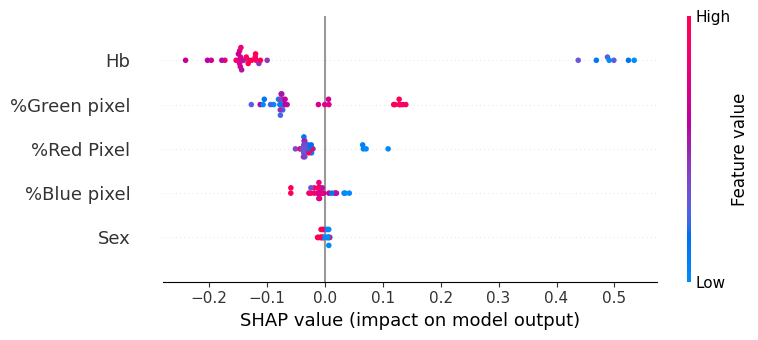

In [99]:
shap.summary_plot(presence_class, X_test)

Se puede observar que para la predicción de la presencia de anemia, la variable que más influencia en la predicción, es la de hemoglobina. Luego sigue el porcentaje de pixeles verdes, de rojos y de azules. El sexo es el que menos influencia tiene.

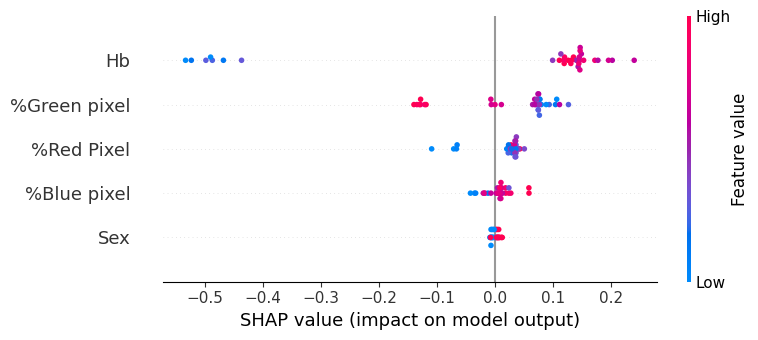

In [100]:
shap.summary_plot(absence_class, X_test)

Se puede observar que para la ausencia de anemia, la variable que más influencia en la predicción, es la de hemoglobina. Luego sigue el porcentaje de pixeles verdes, de rojos y de azules. El sexo es el que menos influencia tiene.

#### **SHAP Dependence Plots**

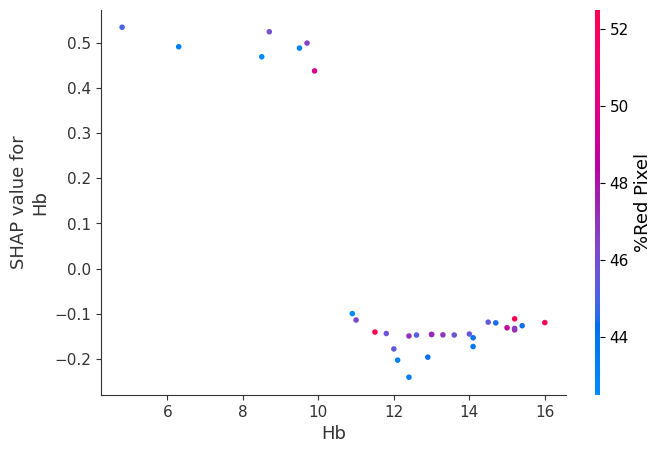

In [101]:
shap.dependence_plot('Hb', presence_class, X_test)

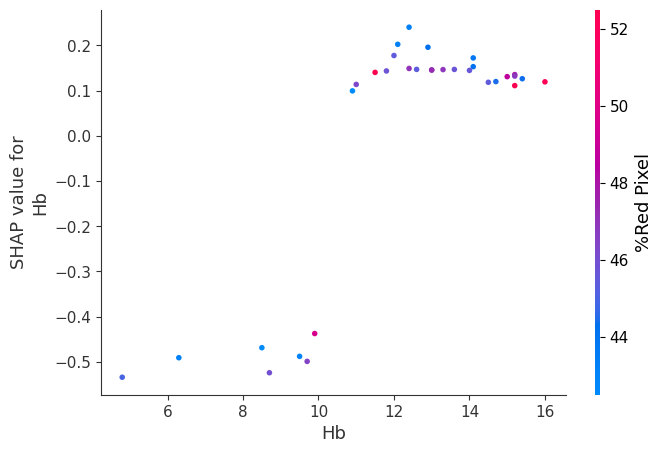

In [103]:
shap.dependence_plot('Hb', absence_class, X_test)

Se puede observar que para la presencia y ausencia de anemia, los valores de Hb son opuestos. Esto quiere decir que mientras más valores de hemoglobina hay, menos probable es que se tenga anemia y viceversa.

#### **SHAP Force Plots**

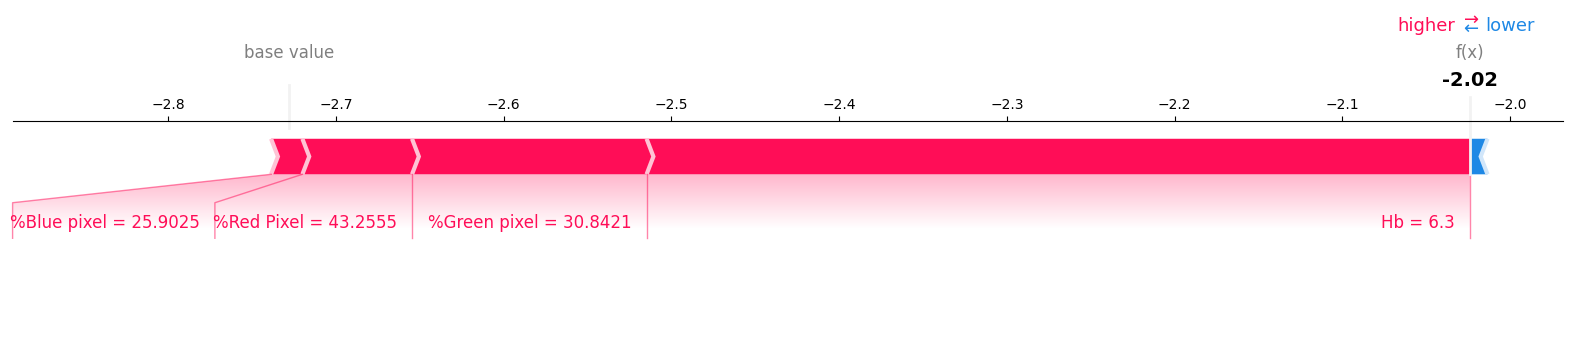

1


In [104]:
# Visualizar la predicción del primer ejemplo en X_test
shap.force_plot(explainer_xgb.expected_value, presence_class[9,:], X_test.iloc[9,:], matplotlib=True)
print(y_test.iloc[9])

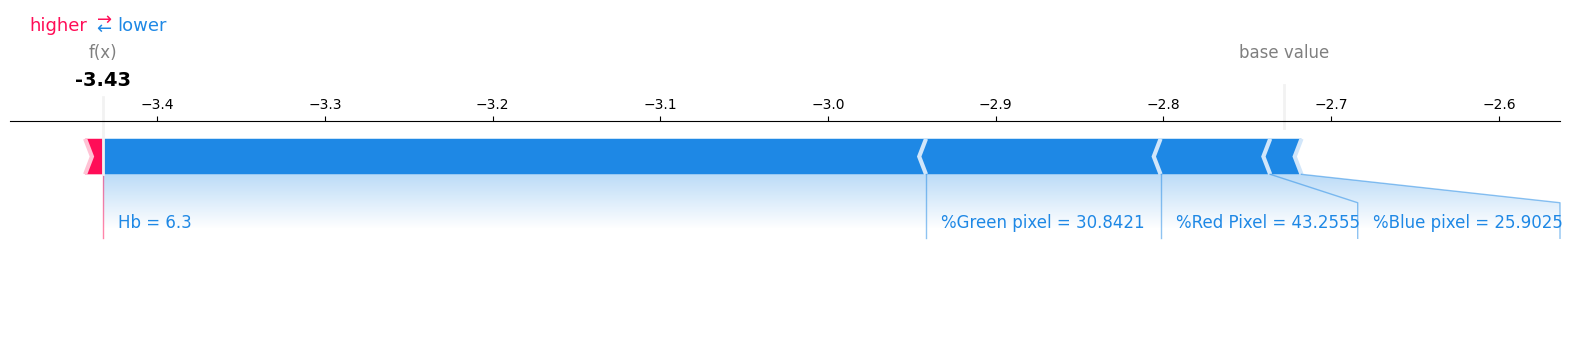

1


In [105]:
# Visualizar la predicción del primer ejemplo en X_test
shap.force_plot(explainer_xgb.expected_value, absence_class[9,:], X_test.iloc[9,:], matplotlib=True)
print(y_test.iloc[9])

En la predicción de la presencia de anemia se puede observar que la variable más importante sigue siendo la hemoglobina, muy por encima de las demás variables.

**Sesgo en predicciones**

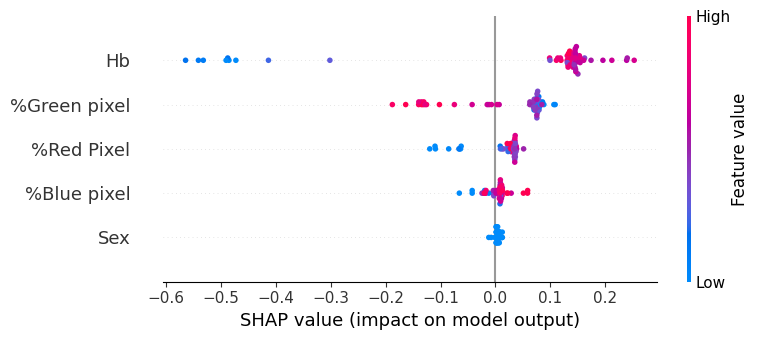

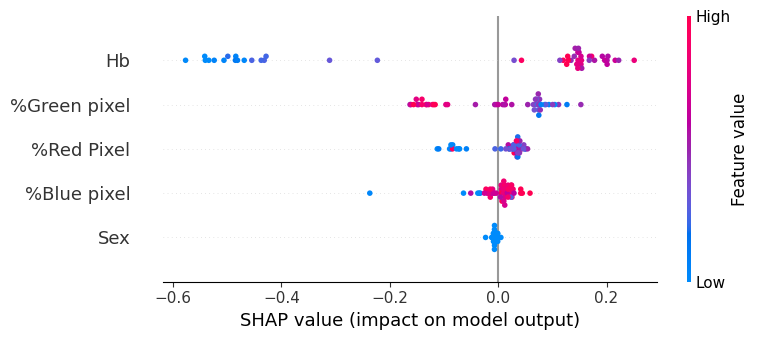

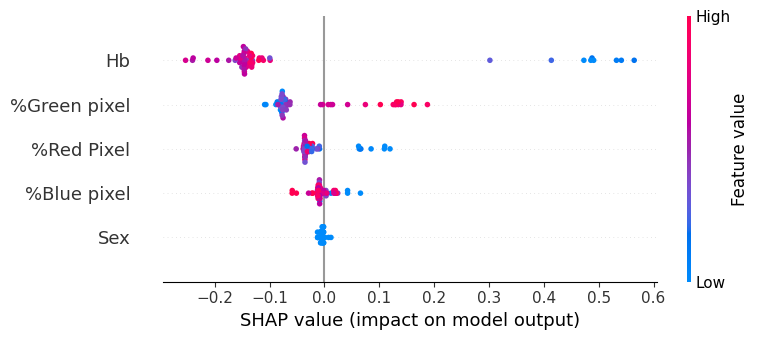

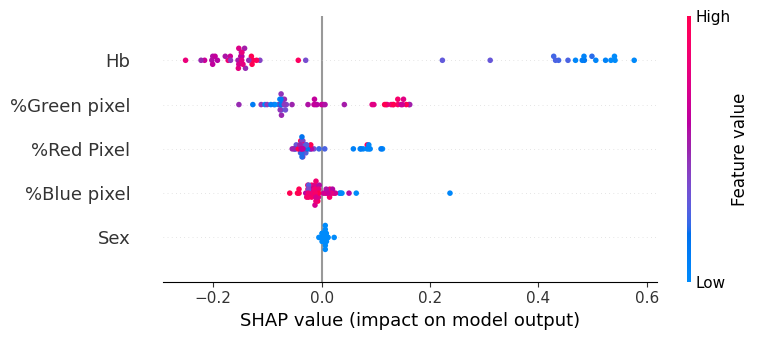

In [109]:
males = X[X['Sex'] == 1]
females = X[X['Sex'] == 0]

shap_values_m = explainer(males)
shap_values_f = explainer(females)

shap.summary_plot(shap_values_m[:, :, 0], males)
shap.summary_plot(shap_values_f[:, :, 0], females)
shap.summary_plot(shap_values_m[:, :, 1], males)
shap.summary_plot(shap_values_f[:, :, 1], females)

Se puede observar que la importancia que se le da a cada feature para realizar las predicciones, dado el género de la persona es muy similar. Por lo tanto, se puede decir que no existe sesgo en las predicciones.

## 5. Conclusión

**Escribir más aquí**

Es importante evidenciar que al usar un método interpretable como el árbol de decisión se obtuvo un resultado muy similar a SHAP, donde la hemoglobina es la variable más importante para predecir la anemia. Además, se pudo evidenciar que el sexo no tiene influencia en la predicción de la anemia.

**Escribir más aquí**